# SwyftModule

In this notebook, we will go through the basic steps of performing parameter inference with Swyft.

## Setup

First we need some imports.

In [15]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [16]:
import numpy as np
import swyft
import pylab as plt
import scipy.stats

## Training data

Now we generate training data.  As simple example, we consider the model

$$
x = z + \epsilon
$$

where the parameter $z \sim \mathcal{N}(\mu = 0, \sigma = 1)$ is standard normal distributed, and $\epsilon \sim \mathcal{N}(\mu = 0, \sigma = 0.1)$ is a small noise contribution.  We are interested in the posterior of $z$ given a measurement of parameter $x$.

In [17]:
N = 10000  # Number of samples
z = np.random.rand(N, 1)*2-1
x = z + np.random.randn(N, 1)*0.1

Training data that is kept in memory is stored in a `swyft.Samples` object.

In [27]:
samples = swyft.Samples(x = x, z = z)

## Inference network

The inference network is an instance of `swyft.SwyftModule`.  It estimates ratios of the form
$$
r(A; B) = \frac{p(A, B)}{p(A)p(B)}\;,
$$
where $A$ and $B$ refer to any subset of variables in the training data.  In the below example, we set $A \to x$ and $B \to z$.

We use here a standard dense network, `swyft.LogRatioEstimator_1dim`, for mapping $x$ and $z$ onto a ratio estimator object.

In [30]:
class Network(swyft.SwyftModule):
    def __init__(self):
        super().__init__()
        self.logratios = swyft.LogRatioEstimator_1dim(num_features = 1, num_params = 1, varnames = 'z')

    def forward(self, A, B):
        logratios = self.logratios(A['x'], B['z'])
        return logratios

## Trainer

Training is now done using the `SwyftTrainer` class, which extends `pytorch_lightning.Trainer` by methods like `infer` (see below).  Since our training data is double precision in this example, we have to set `precision = 64`.

In [31]:
trainer = swyft.SwyftTrainer(accelerator = 'cpu', gpus=1, max_epochs = 10, precision = 64)

GPU available: True, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
/home/weniger/miniconda3b/envs/zero/lib/python3.9/site-packages/pytorch_lightning/trainer/trainer.py:1584: UserWarning: GPU available but not used. Set the gpus flag in your trainer `Trainer(gpus=1)` or script `--gpus=1`.
  rank_zero_warn(


The `swyft.Samples` class provides convenience functions to generate data loaders for training and validation data. We preserve the last 500 samples for validation.

In [32]:
dl_train = samples[:-500].get_dataloader(batch_size = 64, shuffle = True)
dl_valid = samples[-500:].get_dataloader(batch_size = 64)

In [33]:
network = Network()

In [34]:
trainer.fit(network, dl_train, dl_valid)


  | Name      | Type                   | Params
-----------------------------------------------------
0 | logratios | LogRatioEstimator_1dim | 17.4 K
-----------------------------------------------------
17.4 K    Trainable params
0         Non-trainable params
17.4 K    Total params
0.139     Total estimated model params size (MB)
/home/weniger/miniconda3b/envs/zero/lib/python3.9/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:631: UserWarning: Checkpoint directory /home/weniger/codes/swyft/notebooks/lightning_logs/version_9947768/checkpoints exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")


/home/weniger/miniconda3b/envs/zero/lib/python3.9/site-packages/pytorch_lightning/trainer/data_loading.py:132: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 24 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/weniger/miniconda3b/envs/zero/lib/python3.9/site-packages/pytorch_lightning/trainer/data_loading.py:132: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 24 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Epoch 0:  95%|█████████▍| 149/157 [00:01<00:00, 89.32it/s, loss=-0.843, v_num=9947768]
Validating: 0it [00:00, ?it/s]
Epoch 1:  96%|█████████▌| 150/157 [00:01<00:00, 89.80it/s, loss=-0.832, v_num=9947768, val_loss=-.779]
Validating: 0it [00:00, ?it/s]
Epoch 2:  96%|█████████▌| 150/157 [00:01<00:00, 89.53it/s, loss=-0.773, v_num=9947768, val_loss=-.799]
Validating: 0it [00:00, ?it/s]
Epoch 3:  96%|█████████▌| 150/157 [00:01<00:00, 87.33it/s, loss=-0.847, v_num=9947768, val_loss=-.786]
Validating: 0it [00:00, ?it/s]
Epoch 4:  96%|█████████▌| 150/157 [00:01<00:00, 86.49it/s, loss=-0.826, v_num=9947768, val_loss=-.794]
Validating: 0it [00:00, ?it/s]
Epoch 5:  96%|█████████▌| 150/157 [00:01<00:00, 89.35it/s, loss=-0.855, v_num=9947768, val_loss=-.789]
Validating: 0it [00:00, ?it/s]
Epoch 6:   1%|▏         | 2/157 [00:00<00:01, 85.29it/s, loss=-0.85, v_num=9947768, val_loss=-.796]   

/home/weniger/miniconda3b/envs/zero/lib/python3.9/site-packages/pytorch_lightning/trainer/trainer.py:688: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")


## Inference

We assume that we measure the values $x=0.2$.

In [35]:
x0 = 0.2

Below we will need that this is a `Sample` object.

In [36]:
A = swyft.Sample(x = np.array([x0]))

We first generate a large number of prior samples.

In [37]:
B = swyft.Samples(z = np.random.rand(1_000_000, 1)*2-1)

Swyft provides the method `infer` in order to efficiently evaluate the inference network. That method takes either dataloaders or individual samples (i.e. dictionaries of tensors) as input.  This efficiently evaluates the ratio $r(x; z)$ for a large number of prior samples $z$ for a fixed values of $x$.

In [39]:
predictions = trainer.infer(network, A, B)

Predicting: 100%|██████████| 977/977 [00:09<00:00, 100.16it/s]


In [46]:
predictions.parnames[0]

array(['z[0]'], dtype='<U4')

## Plot results

First we obtain samples from the posterior, using subsampling with a weight that happens to be given by $e^r$.

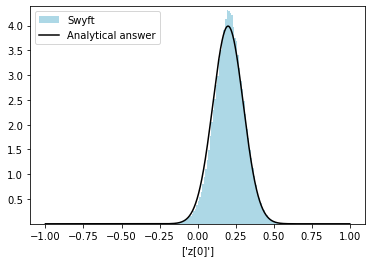

In [47]:
# Plot swyft results
plt.hist(predictions.params[:,0].numpy(), weights = predictions.weights.numpy(),
         bins = 200, density = True, color = 'lightblue', label = "Swyft");
plt.xlabel(predictions.parnames[0])

# Compare with analytical result
xn = np.linspace(-1, 1, 1000)
yn = scipy.stats.norm.pdf(xn, x0, 0.1)
plt.plot(xn, yn, 'k', label = "Analytical answer")
plt.ylim([1e-6, yn.max()*1.1])
#plt.yscale('log')
plt.legend(loc=2)